## Content-based image retrieval by autoencoders

**Content-based image retrieval** (CBIR) is the mechanism of retrieving images relevant to a given query from a large collection of images known as an image database, based on their semantic or visual content rather than on derived attributes or keyword descriptors prescriptively defined for them.

As shown in the picture there are some basic steps involved in query and retrieval:

- Feature extraction: Of course, this part involves the extraction of image characteristics, such as texture, color, etc. It could also be considered a preprocessing step to, for example, resize or improve the quality of the images.
- Similarity measure: The similarity measurement is used to estimate the query image with the database images by similarity. The dissimilarity between the feature vector of the query image and the database images is calculated using different distance metrics. The higher the dissimilarity, the less similar the two images are. Some commonly used distances are: Euclidean distance, block distance, Minkowski distance and Mahalanobis distance.
- Retrieve the results: The N most similar images are displayed to the user.

![CBIR](https://raw.githubusercontent.com/upm-classes/image_mining_2021_2022/main/CBIR/images/cbir_01.jpg)


This notebook is based on the work published by Rupapara et al.[<sup>1</sup>](#fn1). In here special neural network called autoencoder is used for extracting the image features.

### Loading libraries

In [15]:
import os

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

### Loading dataset

In [3]:
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Images come as vectors, so it is necessary to reshape them.
x_train = np.reshape(x_train, (len(x_train), input_shape[0], 
                               input_shape[1], input_shape[2]))
x_test = np.reshape(x_test, (len(x_test), input_shape[0], 
                             input_shape[1], input_shape[2]))

169017344/169001437 [==============================] - 8s 0us/step


### Feature extraction phase: autoencoder

An autoencoder is a neural network that is unsupervised which means that doesn't require any labeled data. 

They work by compressing the input into a latent space representation and reconstructing the output from this representation:

- Encoder: the part of the network that compresses the input into a latent space  representation (i.e., representation of compressed data). It can be represented by an encoding function \\( h=f(x) \\).
- Decoder: This part aims to reconstruct the input from the latent space representation. It can be represented by a decoding function \\( r=g(h) \\).

![CBIR Autoencoder](https://raw.githubusercontent.com/upm-classes/image_mining_2021_2022/main/CBIR/images/cbir_02.jpg)

In [29]:
# Definition of the autoencoder network

def autoencoder_model(input_shape=(32, 32, 3)):
    """ Autoencoder model """
    input_img = Input(shape=input_shape)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

autoencoder = autoencoder_model()
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 8)           9224

#### Autoencoder for denoising

Instead of training the autoencoder to learn an original image and reconstruct it, let's train it, so it can denoise an image. To do this, we modify the input adding some noise will maintain the original image as target.

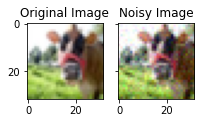

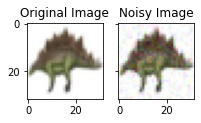

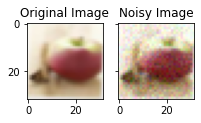

In [30]:
# Adding noise to images
noise_factor = 0.05

x_train_noisy = x_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

for idx in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(3, 3), sharex='col', sharey='row')
    ax[0].imshow(np.squeeze(x_train[idx, ...]))
    ax[0].set_title('Original Image')
    ax[1].imshow(np.squeeze(x_train_noisy[idx, ...]))
    ax[1].set_title('Noisy Image')
    plt.show()

### Training the autoencoder for 20 epochs.

It takes about 40 minutes using a GPU, only because it is a small network and a small dataset. Also we provided a pretrained model that you can use if you don't want to wait one hour.

In [45]:
# Download pretrained model
! wget --no-check-certificate 'https://www.dropbox.com/s/eiqbyxwb7qn6y04/autoencoder_cifar100.h5'
# Download info about training
! wget --no-check-certificate  'https://www.dropbox.com/s/zxe4dhce095gowz/training.log'

--2022-04-20 11:09:28--  https://www.dropbox.com/s/eiqbyxwb7qn6y04/autoencoder_cifar100.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/eiqbyxwb7qn6y04/autoencoder_cifar100.h5 [following]
--2022-04-20 11:09:28--  https://www.dropbox.com/s/raw/eiqbyxwb7qn6y04/autoencoder_cifar100.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0da3044f1c573a44becbbc961e.dl.dropboxusercontent.com/cd/0/inline/BjxATN9W_rG-YoB-Ivo3d1D4EzG7i-vZzK76uol3eG93prhIt0gK8xO6NqvEVqmv0d3d1hOJBBIewFCYxhnZM7Yj-5NMoqPZ5VxemKgIpuYrCuhWXVGjnJqzZFzlM49l1UT7C1lzUizOE3CF74YG3zax1MRyZ-1RkLyVwCVOden1HQ/file# [following]
--2022-04-20 11:09:28--  https://uc0da3044f1c573a44becbbc961e.dl.dropboxusercontent.com/cd/0/inline/BjxATN9W_rG-YoB-Ivo3d1D4EzG7i-vZ

In [46]:
tf.random.set_seed(5)

model_name = 'autoencoder_cifar100.h5'

# Every epoch the model is saved only the the val_loss is smaller that 
# the previous epoch
checkpoint = ModelCheckpoint(filepath=model_name, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min') 
csv_logger = CSVLogger('training.log')


if not os.path.exists(model_name):
    autoencoder = autoencoder_model()
    autoencoder.fit(x_train, x_train_noisy,
                    epochs=20,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(x_test, x_test_noisy),
                    callbacks=[checkpoint, csv_logger])

    autoencoder.save(model_name)
else:
    autoencoder = load_model(model_name)

Let's see some plots about the training phase.

,epoch,loss,val_loss
0,0,0.018088,0.014072
1,1,0.013293,0.012782
2,2,0.012370,0.012438
3,3,0.011824,0.011888
4,4,0.011437,0.011517


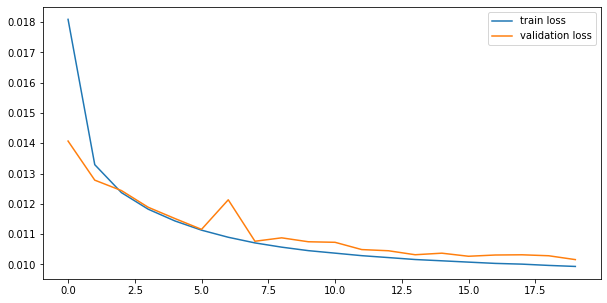

In [47]:
df = pd.read_csv('training.log')
display(df.head())

plt.figure(figsize=(10, 5))
plt.plot(df.epoch, df.loss, label='train loss')
plt.plot(df.epoch, df.val_loss, label='validation loss')
plt.legend()
plt.show()

Let's plot of the result of the denoising

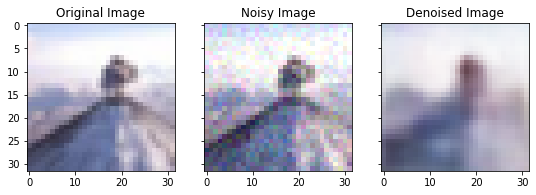

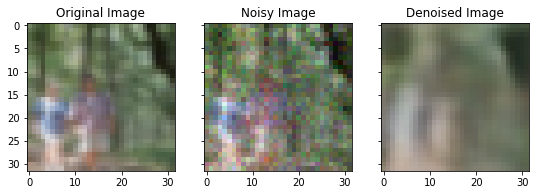

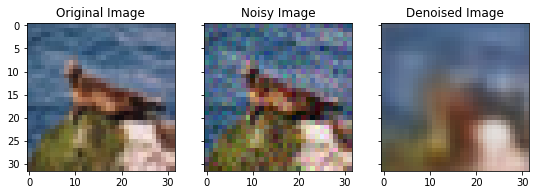

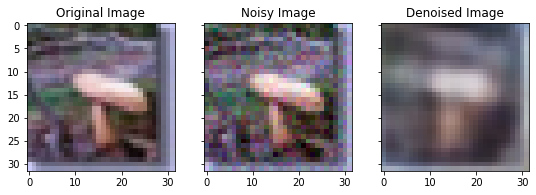

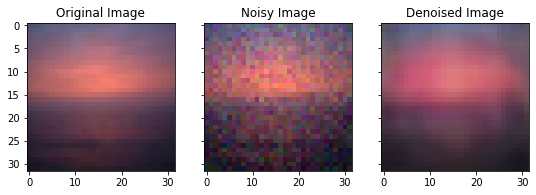

In [48]:
for idx in range(5):
    y = autoencoder.predict(np.expand_dims(x_test_noisy[idx, ...], axis=0))
    
    fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex='col', sharey='row')
    ax[0].imshow(np.squeeze(x_test[idx, ...]))
    ax[0].set_title('Original Image')
    ax[1].imshow(np.squeeze(x_test_noisy[idx, ...]))
    ax[1].set_title('Noisy Image')
    ax[2].imshow(np.squeeze(y))
    ax[2].set_title('Denoised Image')
    plt.show()

### Using the autoencoder for feature extraction (latent space features)

In [50]:
# Obtain features from middle layer
encoder = Model(inputs=autoencoder.input, 
                outputs=autoencoder.get_layer('encoder').output)

In [51]:
# Extracting the features takes some time so we can also download precalculated 
# features
! wget --no-check-certificate 'https://www.dropbox.com/s/epvkaqxa9luhuuq/learned_codes_cifar100.npy'

--2022-04-20 11:12:24--  https://www.dropbox.com/s/epvkaqxa9luhuuq/learned_codes_cifar100.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/epvkaqxa9luhuuq/learned_codes_cifar100.npy [following]
--2022-04-20 11:12:25--  https://www.dropbox.com/s/raw/epvkaqxa9luhuuq/learned_codes_cifar100.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a661a4cd9446a81be61ac00b9.dl.dropboxusercontent.com/cd/0/inline/Bjy8kL7E6TyP6AGc9SEKvBTOvRi_No_4DmY_5tTLvC5TCEUJ_nVwAFZsf1cYua2w42-yPnhPzURuyoRvTnHOFvL83gGWS5XqTEXprtxSdmEwR2GeFAzDZqOcUUbKqCwIfTWWNtc3YNWA3-2ME2x8H1r6Bi8DKy_mesn5KmUJPK2TPA/file# [following]
--2022-04-20 11:12:25--  https://uc3a661a4cd9446a81be61ac00b9.dl.dropboxusercontent.com/cd/0/inline/Bjy8kL7E6TyP6AGc9SEKvBT

In [52]:
# Extracting features from train data
codes_name = 'learned_codes_cifar100.npy'

if not os.path.exists(codes_name):
    learned_codes = encoder.predict(x_train)
    # The sise of the latent space is (None, 4, 4, 8), equivalent to 
    # 512 features per image. So we have to vectorize it.
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * 
                                          learned_codes.shape[2] * 
                                          learned_codes.shape[3])
    np.save(codes_name, learned_codes)
else:
    learned_codes = np.load(codes_name)

In [53]:
def euclidean_distance(x ,y):
    return np.sqrt(np.sum(np.square(x - y)))

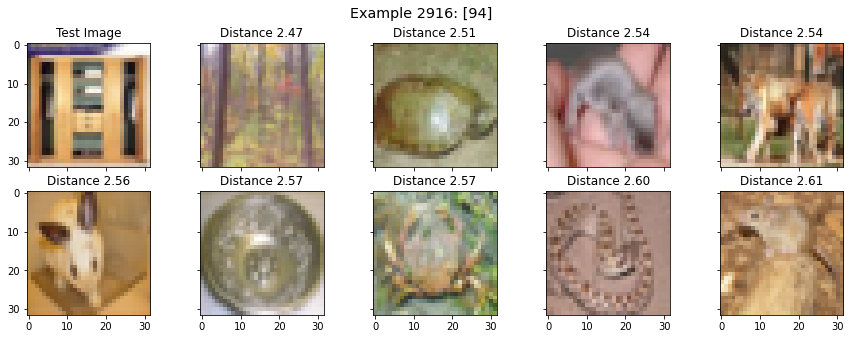

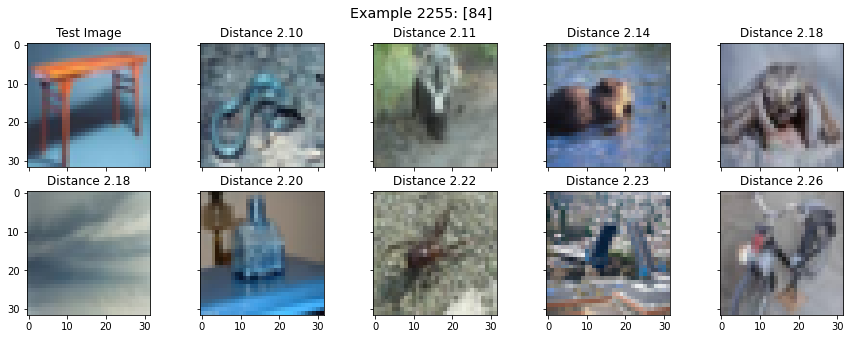

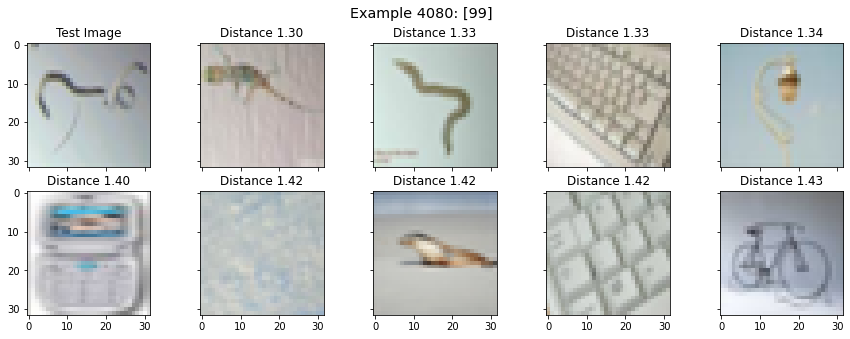

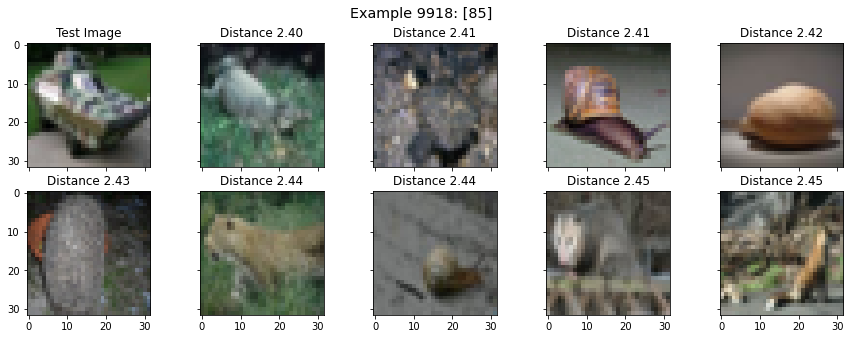

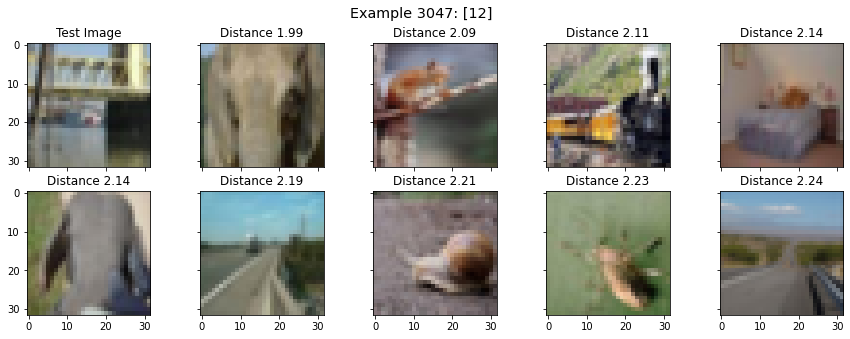

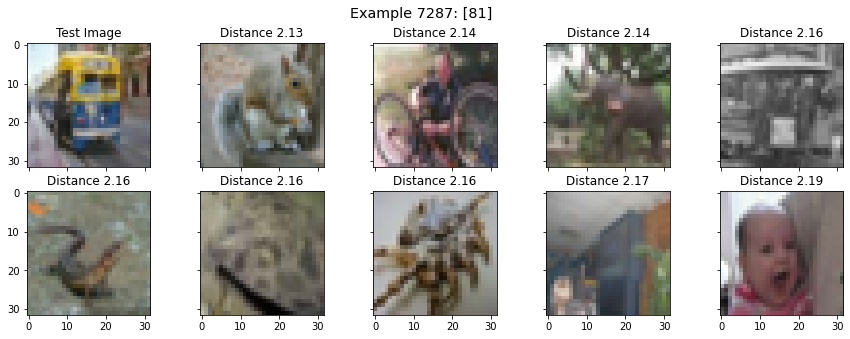

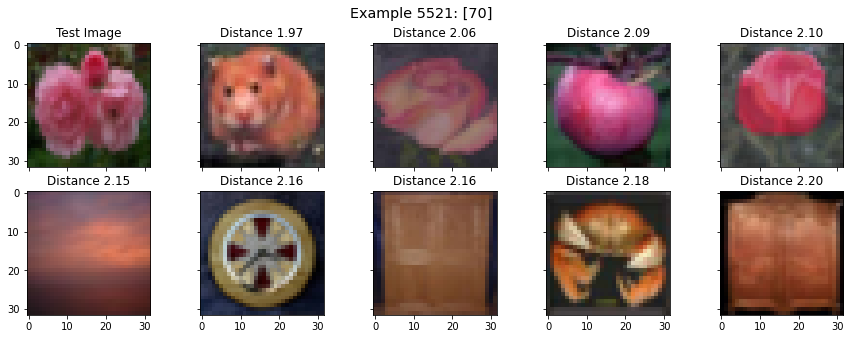

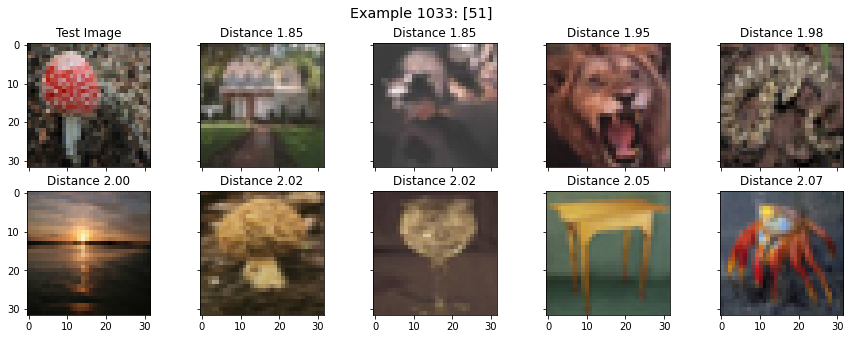

In [54]:
num_retrieve_images = 9
np.random.seed(5)
    
indexes = np.random.randint(0, x_test.shape[0], 8) # Select 8 random images for testing

for idx in indexes:
    # Extract features from test image
    im_test = x_test[idx]
    test_code = encoder.predict(np.expand_dims(im_test, axis=0))
    test_code = test_code.reshape(test_code.shape[0], test_code.shape[1] * 
                                  test_code.shape[2] * test_code.shape[3])
    test_code = np.squeeze(test_code)
    
    # Calculate the distance from
    distances = []
    for code in learned_codes:
        distance = euclidean_distance(code, test_code) # Euclidean norm
        distances.append(distance)
    distances = np.array(distances)
    
    # Ordering the images according to similarity
    sorted_idx = distances.argsort()
    images_idx = sorted_idx[:num_retrieve_images]
    
    # Showing the results
    fig, axes = plt.subplots(int((num_retrieve_images + 1)/5 + 0.5), 5,
                           figsize=(15, 5), sharex='col', sharey='row')
    
    fig.suptitle('Example {}: {}'.format(idx + 1, y_test[idx]), fontsize='x-large')
    for ax_idx, ax in enumerate(axes.flat):
        if ax_idx == 0:
            ax.imshow(np.squeeze(im_test))
            ax.set_title('Test Image')
        else:
            ax.imshow(np.squeeze(x_train[images_idx[ax_idx - 1]]))
            ax.set_title(f'Distance {distances[sorted_idx[ax_idx]]:.2f}')
            
    plt.show()

